In [1]:
# Importer les librairies nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.metrics import make_scorer, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score, StratifiedKFold
import shap
import seaborn as sns
from scipy.stats import chi2_contingency
%matplotlib inline
sns.set_palette("viridis")

# Analyse exploratoire (données regroupées)

In [ ]:
# Télécharger le fichier accident avec comme index Num ACC (Numéro d'identifiant de l’accident)
accidents=pd.read_csv('accidents.csv', index_col='Num_Acc')

# Première aperçu des données
accidents.info()

C:\Users\hayat\AppData\Local\Temp\ipykernel_16508\2562715691.py:2: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  accidents=pd.read_csv('accidents.csv', index_col='Num_Acc')


<class 'pandas.core.frame.DataFrame'>
Index: 764600 entries, 201800000001 to 202200055302
Data columns (total 27 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   an             764600 non-null  int64  
 1   mois           764600 non-null  int64  
 2   lum            764600 non-null  int64  
 3   agg            764600 non-null  int64  
 4   int            764600 non-null  int64  
 5   atm            764600 non-null  float64
 6   col            764600 non-null  float64
 7   dep            764600 non-null  object 
 8   heure          764600 non-null  int64  
 9   jour_semaine   764600 non-null  int64  
 10  catr           764600 non-null  float64
 11  circ           764600 non-null  float64
 12  surf           764600 non-null  float64
 13  infra          764600 non-null  float64
 14  situ           764600 non-null  float64
 15  obs            764600 non-null  float64
 16  obsm           764600 non-null  float64
 17  choc           76

In [3]:
accidents['grav'].value_counts(normalize=True)*100

grav
1.0    45.062647
4.0    37.997253
3.0    14.541721
2.0     2.398378
Name: proportion, dtype: float64

# Transformation de la cible multiclasse en classe binaire

In [3]:
accidents['grav']=accidents['grav'].replace(1.0,0)
accidents['grav']=accidents['grav'].replace(4.0,0)
accidents['grav']=accidents['grav'].replace(2.0,1)
accidents['grav']=accidents['grav'].replace(3.0,1)

In [4]:
accidents['grav'].value_counts()

grav
0.0    635076
1.0    129524
Name: count, dtype: int64

# Séparation du jeu de données

In [ ]:
# Séparation des variables explicatives (noté X) et la cible (noté y)
X=accidents.drop('grav', axis=1)
y=accidents['grav']

# Diviser les données en un ensemble d'entrainement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

# Encodage des variables

In [6]:
# Variables à encoder avec One-Hot Encoding
var_onehot = ['lum', 'agg', 'col', 'jour_semaine', 'catr', 'circ','situ',
                'obsm', 'catu', 'sexe', 'trajet', 'secu_combined']

# Variables à encoder avec Frequency Encoding
var_freq = ['dep', 'manv', 'obs', 'int', 'atm','surf', 'infra', 'choc', 'catv_modifié', 'place']

# Initialiser l'encodeur One-Hot
from sklearn.preprocessing import OneHotEncoder
enc_onehot = OneHotEncoder(sparse_output=False, drop=None)

# Appliquer l'encodage et convertir en DataFrame
X_train_enc = enc_onehot.fit_transform(X_train[var_onehot])
X_train_enc_df = pd.DataFrame(X_train_enc, columns=enc_onehot.get_feature_names_out(var_onehot), index=X_train.index)

# Concaténer avec le DataFrame original
X_train_enc_df = pd.concat([X_train.drop(columns=var_onehot), X_train_enc_df], axis=1)

In [7]:
print(X_train_enc_df.head())

                an  mois  int  atm dep  heure  surf  infra  obs  choc  ...  \
Num_Acc                                                                ...   
201900029512  2019    12    1  8.0  75     16   2.0    1.0  0.0   4.0  ...   
202200029834  2022    11    1  1.0  93     11   1.0    0.0  0.0   1.0  ...   
201900037702  2019     4    1  1.0  38     17   1.0    9.0  0.0   3.0  ...   
202100036445  2021     6    1  1.0  13     17   1.0    0.0  0.0   3.0  ...   
202200027255  2022     4    1  1.0  26     16   1.0    0.0  1.0   1.0  ...   

              trajet_2.0  trajet_3.0  trajet_4.0  trajet_5.0  trajet_9.0  \
Num_Acc                                                                    
201900029512         0.0         0.0         1.0         0.0         0.0   
202200029834         0.0         0.0         0.0         0.0         0.0   
201900037702         0.0         0.0         0.0         0.0         0.0   
202100036445         0.0         0.0         0.0         0.0         0.0 

In [8]:
#Frequency encoding pour X Train
for var in var_freq:
    # Calculer la fréquence de chaque catégorie
    freq_encoding = X_train_enc_df[var].value_counts() / len(X_train_enc_df)
    # Remplacer les catégories par leur fréquence
    X_train_enc_df[var] = X_train_enc_df[var].map(freq_encoding)
X_train_enc_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 611680 entries, 201900029512 to 201800031078
Data columns (total 79 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   an                 611680 non-null  int64  
 1   mois               611680 non-null  int64  
 2   int                611680 non-null  float64
 3   atm                611680 non-null  float64
 4   dep                611680 non-null  float64
 5   heure              611680 non-null  int64  
 6   surf               611680 non-null  float64
 7   infra              611680 non-null  float64
 8   obs                611680 non-null  float64
 9   choc               611680 non-null  float64
 10  manv               611680 non-null  float64
 11  catv_modifié       611680 non-null  float64
 12  place              611680 non-null  float64
 13  age                611680 non-null  float64
 14  lum_1              611680 non-null  float64
 15  lum_2              611680 non-null  flo

In [9]:
X_test_enc=enc_onehot.transform(X_test[var_onehot])
X_test_enc_df = pd.DataFrame(X_test_enc, columns=enc_onehot.get_feature_names_out(var_onehot), index=X_test.index)

# Concaténer avec le DataFrame original
X_test_enc_df = pd.concat([X_test.drop(columns=var_onehot), X_test_enc_df], axis=1)

In [10]:

#Frequency encoding pour X test
for var in var_freq:
    # Calculer la fréquence de chaque catégorie
    freq_encoding = X_test_enc_df[var].value_counts() / len(X_test_enc_df)
    # Remplacer les catégories par leur fréquence
    X_test_enc_df[var] = X_test_enc_df[var].map(freq_encoding)
X_test_enc_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 152920 entries, 201800028911 to 202000028488
Data columns (total 79 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   an                 152920 non-null  int64  
 1   mois               152920 non-null  int64  
 2   int                152920 non-null  float64
 3   atm                152920 non-null  float64
 4   dep                152920 non-null  float64
 5   heure              152920 non-null  int64  
 6   surf               152920 non-null  float64
 7   infra              152920 non-null  float64
 8   obs                152920 non-null  float64
 9   choc               152920 non-null  float64
 10  manv               152920 non-null  float64
 11  catv_modifié       152920 non-null  float64
 12  place              152920 non-null  float64
 13  age                152920 non-null  float64
 14  lum_1              152920 non-null  float64
 15  lum_2              152920 non-null  flo

In [ ]:
# Dimension de mon Dataframe nommé X_enc après encodage
print('train')
n_lignes, n_colonnes = X_train_enc_df.shape
print(n_lignes, n_colonnes)
print()
print('test')
n_lignes1, n_colonnes1 = X_test_enc_df.shape
print(n_lignes1, n_colonnes1)

# On observe que le nombre de colonne a augmenté (79 colonnes) donc l'encodage a bien été réalisé.
# On est passé de 27 variables à 79 variables.

train
611680 79

test
152920 79


# Standardisation des données

In [12]:
# Standardiser les données du Dataframe nommé X_enc
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train_enc_df)
X_test_scaled=scaler.transform(X_test_enc_df)

# Rééchantillonage des données

In [ ]:
# Rééchantillonnage des données avec la technique d'échantillonnage undersampling
undersamp = RandomUnderSampler()
X_train_undersamp, y_train_undersamp = undersamp.fit_resample(X_train_scaled, y_train)

In [15]:
# On va vérifier que les classes sont rééquilibrées
y_train_undersamp.value_counts(normalize=True)*100

grav
0.0    50.0
1.0    50.0
Name: proportion, dtype: float64

In [14]:
# Mapping des classes pour affichage lisible
y_label = {0: "0 - Léger", 1: "1 - Grave"}

# Modèles testés

1 : Regression Logsistique

In [ ]:
# Initialisation du modèle
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train_undersamp, y_train_undersamp)

# Prédictions
y_pred = clf.predict(X_test_scaled)

# Matrice de confusion avec labels
y_pred_series = pd.Series(y_pred, index=y_test.index)
y_test_named = y_test.replace(y_label)
y_pred_named = y_pred_series.replace(y_label)

# # Calcul du Recall pour la classe 1
recall_classe_1 = recall_score(y_test, y_pred, pos_label=1)
print(f"Recall sur la classe 1 : {recall_classe_1:.2f}\n")

# Matrice de confusion
print("Matrice de confusion\n")
confusion = pd.crosstab(
    y_test_named, y_pred_named, 
    rownames=['Classe réelle'], 
    colnames=['Classe prédite']
)
print(confusion, "\n")
print('')

# Rapport de classification 
print('Rapport de classification \n')
print(classification_report(y_test, y_pred, target_names=["0 - Léger", "1 - Grave"]))

Recall sur la classe 1 : 0.77

Matrice de confusion

Classe prédite  0 - Léger  1 - Grave
Classe réelle                       
0 - Léger           90844      36411
1 - Grave            5791      19874 


Rapport de classification 

              precision    recall  f1-score   support

   0 - Léger       0.94      0.71      0.81    127255
   1 - Grave       0.35      0.77      0.49     25665

    accuracy                           0.72    152920
   macro avg       0.65      0.74      0.65    152920
weighted avg       0.84      0.72      0.76    152920



1 : Regression Logsistique avec GridSearchCV et  hyperparamètres 

In [ ]:
# Définir la grille de paramètres
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10],
    'solver': ['liblinear', 'saga'],  
    'max_iter': [1000],
    'class_weight': ['balanced', {0: 2, 1: 1}, {0: 3, 1: 1}]
}

# Scoring Recall sur la classe 1
scoring = make_scorer(recall_score, pos_label=1)

# Initialisation du modèle
clf = LogisticRegression()

# GridSearchCV
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring=scoring,
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Entraînement
grid_search.fit(X_train_undersamp, y_train_undersamp)

# Meilleurs paramètres
print('\nMeilleurs paramètres trouvés :\n')
print(grid_search.best_params_)

# Affichage du meilleur modèle et de ses prédictions
best_clf = grid_search.best_estimator_
y_pred = best_clf.predict(X_test_scaled)

y_pred_series = pd.Series(y_pred, index=y_test.index)
y_test_named = y_test.replace(y_label)        
y_pred_named = y_pred_series.replace(y_label)

# Calcul du Recall sur la classe 1
recall_classe_1 = recall_score(y_test, y_pred, pos_label=1)
print(f"Recall sur la classe 1 : {recall_classe_1:.2f}\n")

# Matrice de confusion
print('\nMatrice de confusion\n')
print(pd.crosstab(y_test_named, y_pred_named, rownames=['classe réelle'], colnames=['classe prédite']))

# Rapport de classification 
print('\nRapport de classification\n')
print(classification_report(y_test, y_pred, target_names=["0 - Léger", "1 - Grave"]))

Fitting 3 folds for each of 48 candidates, totalling 144 fits

Meilleurs paramètres trouvés :

{'C': 0.01, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}

Recall sur la classe 1 : 77.37 %


Matrice de confusion

classe prédite  0 - Léger  1 - Grave
classe réelle                       
0 - Léger           90839      36416
1 - Grave            5807      19858

Rapport de classification

              precision    recall  f1-score   support

   0 - Léger       0.94      0.71      0.81    127255
   1 - Grave       0.35      0.77      0.48     25665

    accuracy                           0.72    152920
   macro avg       0.65      0.74      0.65    152920
weighted avg       0.84      0.72      0.76    152920



2 : Random Forest

In [ ]:
# Initialisation du modèle 
rf = RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42)

# Entraînement
rf.fit(X_train_undersamp, y_train_undersamp)

# Prédiction
y_pred = rf.predict(X_test_scaled)

y_pred_series = pd.Series(y_pred, index=y_test.index)
y_test_named = y_test.replace(y_label)
y_pred_named = y_pred_series.replace(y_label)

# Calcul du Recall sur la classe 1
recall_classe_1 = recall_score(y_test, y_pred, pos_label=1)
print(f"Recall sur la classe 1 : {recall_classe_1:.2f}\n")

# Matrice de confusion 
print('\nMatrice de confusion\n')
print(pd.crosstab(y_test_named, y_pred_named, rownames=['classe réelle'], colnames=['classe prédite']))

# Rapport de classification 
print('\nRapport de classification\n')
print(classification_report(y_test, y_pred, target_names=["0 - Léger", "1 - Grave"]))

Recall sur la classe 1 : 0.82


Matrice de confusion

classe prédite  0 - Léger  1 - Grave
classe réelle                       
0 - Léger           97788      29467
1 - Grave            4728      20937

Rapport de classification

              precision    recall  f1-score   support

   0 - Léger       0.95      0.77      0.85    127255
   1 - Grave       0.42      0.82      0.55     25665

    accuracy                           0.78    152920
   macro avg       0.68      0.79      0.70    152920
weighted avg       0.86      0.78      0.80    152920



2 bis : Random forest avec RandomizedSearchCV et hyperparamètres 

In [ ]:
# Définir la grille de paramètres 
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, 20, None],
    'class_weight': ['balanced', {0: 2, 1: 1}],  
    'min_samples_split': [2, 5, 10]
}

# Scoring Recall sur la classe 1
scoring = make_scorer(recall_score, pos_label=1)

# Initialisation du modèle de base 
rf = RandomForestClassifier(random_state=42)

# Initialisation du RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid_rf,
    scoring=scoring,
    cv=3,
    n_jobs=-1,
    n_iter=5,         
    random_state=42,
    verbose=1
)

# Entraînement
random_search.fit(X_train_undersamp, y_train_undersamp)

# Meilleurs paramètres 
print("\nMeilleurs paramètres trouvés :\n")
print(random_search.best_params_)

# Affichage du meilleur modèle et de ses prédictions
best_rf = random_search.best_estimator_
y_pred = best_rf.predict(X_test_scaled)

y_pred_series = pd.Series(y_pred, index=y_test.index)
y_test_named = y_test.replace(y_label)
y_pred_named = y_pred_series.replace(y_label)

# Calcul du Recall sur la classe 1
recall_classe_1 = recall_score(y_test, y_pred, pos_label=1)
print(f"\nRecall sur la classe 1 : {recall_classe_1:.2f}\n")

# Matrice de confusion
print("\nMatrice de confusion\n")
print(pd.crosstab(y_test_named, y_pred_named, rownames=['classe réelle'], colnames=['classe prédite']))

# Rapport de classification 
print("\nRapport de classification\n")
print(classification_report(y_test, y_pred, target_names=["0 - Léger", "1 - Grave"]))


Fitting 3 folds for each of 5 candidates, totalling 15 fits

Meilleurs paramètres trouvés :

{'n_estimators': 100, 'min_samples_split': 2, 'max_depth': None, 'class_weight': {0: 2, 1: 1}}

Recall sur la classe 1 : 0.82


Matrice de confusion

classe prédite  0 - Léger  1 - Grave
classe réelle                       
0 - Léger           96922      30333
1 - Grave            4647      21018

Rapport de classification

              precision    recall  f1-score   support

   0 - Léger       0.95      0.76      0.85    127255
   1 - Grave       0.41      0.82      0.55     25665

    accuracy                           0.77    152920
   macro avg       0.68      0.79      0.70    152920
weighted avg       0.86      0.77      0.80    152920



3 : KNN 

In [ ]:
# Définition du modèle
knn = KNeighborsClassifier()

# Entraînement du modèle
knn.fit(X_train_undersamp, y_train_undersamp)

# Prédictions
y_pred = knn.predict(X_test_scaled)

# Calcul du Recall sur la classe 1
recall_classe_1 = recall_score(y_test, y_pred, pos_label=1)
print(f"\nRecall sur la classe 1 : {recall_classe_1:.2f}\n")

# Matrice de confusion
print("Matrice de confusion :\n")
print(pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=[' Classe prédite']), "\n")

# Rapport de classification
print("Rapport de classification :\n")
print(classification_report(y_test, y_pred, target_names=["0 - Léger", "1 - Grave"]))


Recall sur la classe 1 : 0.76

Matrice de confusion :

 Classe prédite    0.0    1.0
Classe réelle                
0.0              89702  37553
1.0               6252  19413 

Rapport de classification :

              precision    recall  f1-score   support

   0 - Léger       0.93      0.70      0.80    127255
   1 - Grave       0.34      0.76      0.47     25665

    accuracy                           0.71    152920
   macro avg       0.64      0.73      0.64    152920
weighted avg       0.84      0.71      0.75    152920



3 bis : KNN avec RandomizedSearchCV et hyperparamètres 

In [ ]:
# Initialisation du modèle
knn_under = KNeighborsClassifier()

# Définition des hyperparamètres à tester
param_grid = {
    'n_neighbors': [3, 5 ,7, 9],  
    'metric': ['minkowski', 'manhattan'],  
    'weights': ['uniform', 'distance'] }

# RandomizedSearchCV avec validation croisée
random_search_under_knn = RandomizedSearchCV(knn_under, param_grid, cv=3, scoring='recall', n_jobs=-1, n_iter=5, random_state=42)
random_search_under_knn.fit(X_train_undersamp, y_train_undersamp)

# Affichage des meilleurs paramètres 
print("Meilleurs paramètres :", random_search_under_knn.best_params_, "\n")

# Affichage du meilleur modèle et de ses prédictions
best_knn = random_search_under_knn.best_estimator_
y_pred_under_knn = best_knn.predict(X_test_scaled)

y_pred_series = pd.Series(y_pred_under_knn, index=y_test.index)
y_test_named = y_test.replace(y_label)
y_pred_named = y_pred_series.replace(y_label)

# Calcul du recall sur la classe 1
recall_classe_1 = recall_score(y_test, y_pred_under_knn, pos_label=1)
print(f"\nRecall sur la classe 1 : {recall_classe_1:.2f}\n")

# Matrice de confusion lisible
print("Matrice de confusion", "\n")
print(pd.crosstab(y_test_named, y_pred_named, rownames=['classe réelle'], colnames=['classe prédite']), "\n")

# Classification report avec labels renommés
print("Rapport de classification", "\n")
print(classification_report(y_test, y_pred_under_knn, target_names=["0 - Léger", "1 - Grave"]), "\n")

Meilleurs paramètres : {'weights': 'distance', 'n_neighbors': 7, 'metric': 'manhattan'} 


Recall sur la classe 1 : 0.79

Matrice de confusion 

classe prédite  0 - Léger  1 - Grave
classe réelle                       
0 - Léger           91919      35336
1 - Grave            5467      20198 

Rapport de classification 

              precision    recall  f1-score   support

   0 - Léger       0.94      0.72      0.82    127255
   1 - Grave       0.36      0.79      0.50     25665

    accuracy                           0.73    152920
   macro avg       0.65      0.75      0.66    152920
weighted avg       0.85      0.73      0.76    152920
 



4 - XGBoost avec GridSearchCV et hyperaramètres

In [ ]:
# Initialisation du modèle
xgb_clf = XGBClassifier()

# Définition des hyperparamètres à tester
param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'subsample': [0.8, 1.0],
    'n_estimators': [50, 100],
    'colsample_bytree': [0.7, 0.8, 1.0]
}

# GridSearchCV avec validation croisée
grid_search_under_xgb = GridSearchCV(xgb_clf, param_grid, cv=3, scoring='recall', n_jobs=-1)
grid_search_under_xgb.fit(X_train_undersamp, y_train_undersamp)

# Affichage des meilleurs paramètres
print("Meilleurs paramètres :", grid_search_under_xgb.best_params_, "\n")

# Affichage du meilleur modèle et de ses prédictions
best_xgb = grid_search_under_xgb.best_estimator_
y_pred_under_xgb = best_xgb.predict(X_test_scaled)

y_pred_series = pd.Series(y_pred_under_xgb, index=y_test.index)
y_test_named = y_test.replace(y_label)
y_pred_named = y_pred_series.replace(y_label)

# Calcul du Recall sur la classe 1
recall_classe_1 = recall_score(y_test, y_pred_under_xgb, pos_label=1)
print(f"\nRecall sur la classe 1 : {recall_classe_1:.2f}\n")

# Matrice de confusion 
print("Matrice de confusion", "\n")
print(pd.crosstab(y_test_named, y_pred_named, rownames=['classe réelle'], colnames=['classe prédite']), "\n")

# Classification report avec labels renommés
print("Rapport de classification", "\n")
print(classification_report(y_test, y_pred_under_xgb, target_names=["0 - Léger", "1 - Grave"]), "\n")

Meilleurs paramètres : {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0} 


Recall sur la classe 1 : 0.91

Matrice de confusion 

classe prédite  0 - Léger  1 - Grave
classe réelle                       
0 - Léger           52753      74502
1 - Grave            2218      23447 

Rapport de classification 

              precision    recall  f1-score   support

   0 - Léger       0.96      0.41      0.58    127255
   1 - Grave       0.24      0.91      0.38     25665

    accuracy                           0.50    152920
   macro avg       0.60      0.66      0.48    152920
weighted avg       0.84      0.50      0.55    152920
 



# Conclusion

Dans ce notebook, le modèle le plus performant est le Random Forest avec recherche d’hyperparamètres, car il présente le meilleur équilibre entre les trois métriques étudiées pour ce projet : le rappel et la précision sur la classe 1, ainsi que la précision sur la classe 0.
Nous allons maintenant analyser l’importance des différentes variables dans ce modèle.
Nous afficherons les 10 variables les plus influentes, c’est-à-dire celles qui ont le plus contribué aux décisions du modèle, en particulier celles ayant un impact sur le rappel de la classe 1.

In [ ]:
# Récupérer l'importance de chaque variable, selon l'influence qu'elle a eue dans les prédictions du modèleRandom Forest
importances = best_rf.feature_importances_

# Associer chaque importance à sa variable
feature_names = X_train_enc_df.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Classer les variables selon leur importance décroissante dans le modèle
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Affichage du top 10 des variables les plus influentes
print("Top 10 des variables significatives :")
print(feature_importance_df.head(10).to_string(index=False))

#  Visualisation
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:10][::-1], feature_importance_df['Importance'][:10][::-1])
plt.xlabel("Importance")
plt.title("Top 10 variables les plus significatives (Random Forest)")
plt.tight_layout()
plt.show()

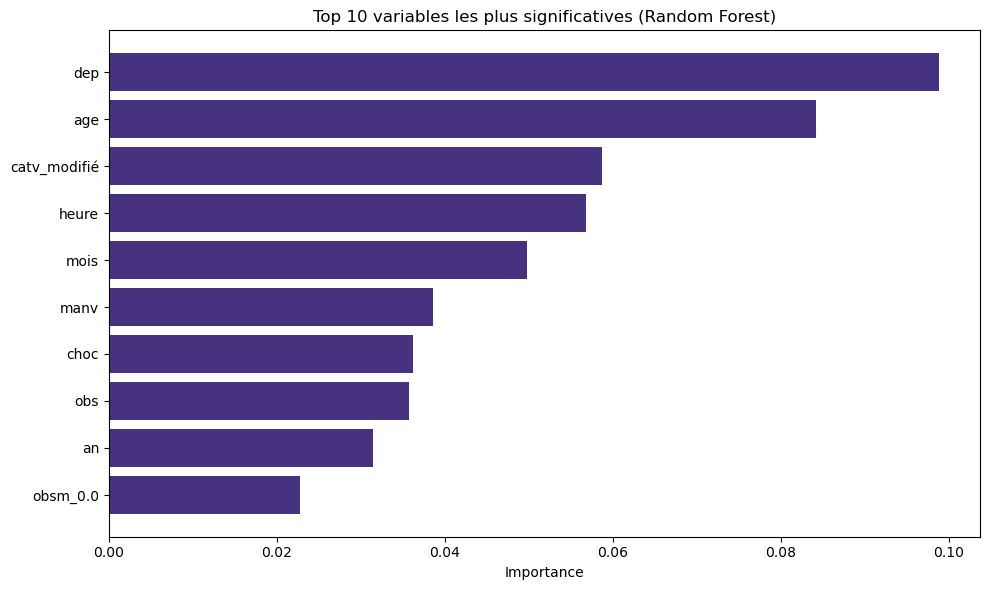